# Teaching Myself Retrieval-Augmented Generation (RAG) with PDFs  
INFO 7390 – Advanced Data Science and Architecture

This notebook is a **learning-by-doing** tutorial where I will:

1. Build a **minimal RAG system** from scratch:
   - Load 1+ PDFs
   - Split them into chunks
   - Embed the chunks
   - Store them in a simple vector store
   - Retrieve relevant chunks for a question
   - Use an LLM (OpenAI) to answer based on those chunks

2. Understand the **concepts behind each step**:
   - Why chunking matters
   - What embeddings are
   - How cosine similarity works
   - Why retrieval helps reduce hallucinations

3. Experiment:
   - Change chunk size / overlap
   - Add multiple PDFs
   - See what happens to answer quality

---

## Learning Objectives

By the end of this notebook I should be able to:

- Explain what RAG is (in my own words).
- Implement a basic PDF Q&A assistant.
- Inspect which chunks the model actually used.
- Debug common RAG failure modes.
- Suggest extensions (e.g., different models, better vector stores).


In [3]:
# If running in a fresh environment, uncomment and run this once.
# In your final project, these go into requirements.txt instead.

!pip install -q pypdf sentence-transformers openai python-dotenv



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Setup

In this section I will:

- Import all the libraries I need.
- Configure my API key for OpenAI.
- Do a quick sanity check that everything is working.


In [4]:
import os
from pathlib import Path
from typing import List, Tuple

import numpy as np
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv

from openai import OpenAI


In [5]:
# Load environment variables from .env if present
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    raise ValueError(
        "OPENAI_API_KEY not found. Set it in your environment or in a .env file."
    )

# OpenAI client (uses OPENAI_API_KEY from env)
client = OpenAI()

# Quick sanity check: list a model name we plan to use.
# (This is just a variable; we won't call API here yet.)
OPENAI_MODEL_NAME = "gpt-4.1-mini"  # change to another model if you want
OPENAI_MODEL_NAME


'gpt-4.1-mini'

## 2. A Simple LLM Client (OpenAI)

To keep the rest of the notebook clean, I'll create a tiny wrapper around the
OpenAI Chat Completions API.

If I later switch to another provider, I only need to change this class.


In [6]:
class OpenAILLMClient:
    def __init__(self, model_name: str = OPENAI_MODEL_NAME):
        self.client = client
        self.model_name = model_name

    def generate(self, prompt: str) -> str:
        """
        Generate text from a prompt using OpenAI's Chat Completions.
        """
        completion = self.client.chat.completions.create(
            model=self.model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.content

# Instantiate a global client for the notebook
llm = OpenAILLMClient()


## 3. What is RAG? (Conceptual Overview)

**Retrieval-Augmented Generation (RAG)** is a pattern where we:

1. Take a **user question**.
2. **Retrieve** relevant information from an external knowledge base
   (e.g., PDFs, docs, database).
3. Feed the **retrieved context + question** into an LLM.
4. Let the LLM generate an answer that is *grounded* in that context.

Why this matters:

- Pure LLMs:
  - Limited by their training data cutoff.
  - Can hallucinate details.
  - Don't know my private PDFs.

- RAG:
  - Lets me point the LLM at **my own data**.
  - Reduces hallucinations (not eliminates).
  - Is easier/cheaper than fine-tuning in many cases.

In this notebook, my "knowledge base" will be **one or more PDFs**.


## 4. Loading PDF Text

First, I need to:

- Read one or more PDFs.
- Extract the text from all pages.
- Concatenate it into a single string.

I will start with a helper function that takes a list of PDF paths and returns
one long text string.


In [7]:
def load_pdfs(pdf_paths: List[str]) -> str:
    """
    Load one or more PDFs and return their text as a single concatenated string.
    """
    texts = []
    for path in pdf_paths:
        reader = PdfReader(path)
        # Some pages may have None for extract_text(), so coalesce with ""
        pages = [page.extract_text() or "" for page in reader.pages]
        texts.append("\n".join(pages))
    return "\n".join(texts)

# 🔧 Set your PDF path(s) here:
pdf_dir = Path("data/sample_papers")
pdf_dir.mkdir(parents=True, exist_ok=True)

# Example: add your own PDF here, e.g. "paper1.pdf"
sample_pdf_paths = [
    str(pdf_dir / "paper1.pdf"),  # TODO: put an actual PDF in this location
    # str(pdf_dir / "paper2.pdf"),
]

# For now, check what files exist:
list(pdf_dir.iterdir())


[PosixPath('data/sample_papers/paper1.pdf'),
 PosixPath('data/sample_papers/paper3.pdf'),
 PosixPath('data/sample_papers/paper2.pdf')]

In [8]:
raw_text = load_pdfs(sample_pdf_paths)

print("Total number of characters:", len(raw_text))
print("\nFirst 1000 characters:\n")
print(raw_text[:1000])


Total number of characters: 2447

First 1000 characters:

=== PRODUCT REPORT ===
1. Basic Product Details
    Category: Phone case
    Price: $20.00
    AI Caption (from image): pink phone case with panda design
2. Image Analysis
    Color: pink
    Material: N/A
    Style: cute
    Visible Features: panda design, imported premium case
3. Seller Description
    Original Text: Pink Phone Case
    Tone: minimal
    Keywords: pink, phone case
    Claims: the product is a phone case, the color is pink
    Implied Benefits: protects the phone, adds a stylish look
    AI Category Guess: phone case
4. Consistency & Risk
    Similarity between image and description: 0.726
    Risk Score (0 = safe, 100 = risky): 0.0
    Missing Info: None detected
    Contradictions: None detected
5. Simulated Customer Reviews (by Rating)
   --- 5-Star Review ---
   Title: Absolutely Adorable!
   Review: I absolutely love this pink panda phone case! It's not only super cute, but it
also provide

## 5. Chunking Text

LLMs and embedding models usually work best with **chunks**, not entire books.

Why chunk?

- Embedding an entire long document into one vector loses local details.
- Retrieval needs **smaller units** (paragraphs / sections) to be precise.
- We want the model to see only the most relevant parts, not everything.

Design decisions:
- **Chunk size (in tokens or words):** bigger chunks = more context but less precise.
- **Overlap:** we often overlap chunks to avoid cutting sentences in half.

Here I'll implement a simple **word-based chunker with overlap**.


In [9]:
from typing import List

def chunk_text(text: str, chunk_size: int = 200, chunk_overlap: int = 50) -> List[str]:
    """
    Split text into overlapping word-based chunks.
    
    chunk_size: number of words per chunk
    chunk_overlap: number of words to overlap between consecutive chunks
    """
    words = text.split()
    chunks = []
    start = 0
    
    while start < len(words):
        end = start + chunk_size
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - chunk_overlap  # move window forward, with overlap
    
    return chunks

# Let's chunk our document
chunks = chunk_text(raw_text, chunk_size=200, chunk_overlap=50)
len(chunks), chunks[0][:300]


(3,
 '=== PRODUCT REPORT === 1. Basic Product Details \x7f Category: Phone case \x7f Price: $20.00 \x7f AI Caption (from image): pink phone case with panda design 2. Image Analysis \x7f Color: pink \x7f Material: N/A \x7f Style: cute \x7f Visible Features: panda design, imported premium case 3. Seller Description \x7f Original T')

In [10]:
for i in range(min(3, len(chunks))):
    print(f"--- Chunk {i} ---")
    print(chunks[i][:500])
    print()


--- Chunk 0 ---
=== PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  Style: cute  Visible Features: panda design, imported premium case 3. Seller Description  Original Text: Pink Phone Case  Tone: minimal  Keywords: pink, phone case  Claims: the product is a phone case, the color is pink  Implied Benefits: protects the phone, adds a stylish look  AI Category Gue

--- Chunk 1 ---
also provides excellent protection for my phone. The design is vibrant and the case fits perfectly without adding bulk. I've received numerous compliments from friends. It feels durable and the price is just right at $20. Highly recommend if you want to add a little fun to your phone! --- 4-Star Review --- Title: Cute and Functional! Review: This panda phone case is super cute and definitely stands out! I love the soft pink color and the design is adorable. It f

## 6. Embeddings: Turning Text into Vectors

Next step: turn chunks into **embeddings**.

- An embedding is a vector (e.g., 384 or 768 dimensions).
- Similar meanings → similar vectors (high cosine similarity).
- We'll use `sentence-transformers` for this (e.g., `all-MiniLM-L6-v2`).

Steps:
1. Load the embedding model.
2. Embed all chunks → matrix of shape `(num_chunks, dim)`.
3. Embed queries the same way.
4. Compare query embedding to chunk embeddings using cosine similarity.


In [11]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

embedder_model = SentenceTransformer(EMBEDDING_MODEL_NAME)

def embed_documents(texts: List[str]) -> np.ndarray:
    """
    Embed a list of texts into a 2D numpy array.
    """
    embeddings = embedder_model.encode(texts, show_progress_bar=True)
    return np.array(embeddings)

def embed_query(text: str) -> np.ndarray:
    """
    Embed a single query string.
    """
    embedding = embedder_model.encode([text])
    return np.array(embedding)[0]

# Compute embeddings for all chunks
chunk_embeddings = embed_documents(chunks)
chunk_embeddings.shape


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(3, 384)

## 7. Simple Vector Store (In-Memory)

Now I need a way to:

1. Store all chunk embeddings + original text.
2. Given a query, find the **top-k most similar chunks**.

I'll implement:

- A `cosine_similarity` function.
- A `SimpleVectorStore` class that:
  - Stores `embeddings` and `texts`.
  - Has a `.search(query_embedding, k)` method.

This is intentionally simple and all in memory → great for teaching.


In [12]:
from dataclasses import dataclass

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return float(a @ b / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10))

@dataclass
class SimpleVectorStore:
    embeddings: np.ndarray   # shape (n_docs, dim)
    texts: List[str]

    def search(self, query_embedding: np.ndarray, k: int = 5) -> List[Tuple[str, float]]:
        sims = [cosine_similarity(query_embedding, e) for e in self.embeddings]
        idxs = np.argsort(sims)[::-1][:k]
        return [(self.texts[i], sims[i]) for i in idxs]

# Build the store
vector_store = SimpleVectorStore(
    embeddings=chunk_embeddings,
    texts=chunks
)


## 8. Testing Retrieval (Without LLM)

Before involving the LLM, I want to make sure **retrieval itself works**.

I'll:

- Ask a question as a plain text query.
- Embed it.
- Use `vector_store.search(...)` to get top-k chunks.
- Inspect the retrieved chunks and similarity scores.


In [13]:
def retrieve_chunks(question: str, k: int = 5) -> List[Tuple[str, float]]:
    q_emb = embed_query(question)
    results = vector_store.search(q_emb, k=k)
    return results

sample_question = "What is this paper mainly about?"  # Change to fit your PDF
results = retrieve_chunks(sample_question, k=3)

for i, (chunk, score) in enumerate(results):
    print(f"--- Retrieved chunk {i} (score={score:.4f}) ---")
    print(chunk[:500])
    print()


--- Retrieved chunk 0 (score=0.1736) ---
=== PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  Style: cute  Visible Features: panda design, imported premium case 3. Seller Description  Original Text: Pink Phone Case  Tone: minimal  Keywords: pink, phone case  Claims: the product is a phone case, the color is pink  Implied Benefits: protects the phone, adds a stylish look  AI Category Gue

--- Retrieved chunk 1 (score=0.1641) ---
also provides excellent protection for my phone. The design is vibrant and the case fits perfectly without adding bulk. I've received numerous compliments from friends. It feels durable and the price is just right at $20. Highly recommend if you want to add a little fun to your phone! --- 4-Star Review --- Title: Cute and Functional! Review: This panda phone case is super cute and definitely stands out! I love th

## 9. RAG: Retrieval + Generation

Now it's time to connect retrieval with the LLM.

Steps:

1. Take a user question.
2. Retrieve top-k chunks and their scores.
3. Build a prompt that:
   - Includes the retrieved context.
   - Includes the question.
   - Instructs the model to **only** use the context and to say "I don't know"
     if the answer is not present.
4. Call the OpenAI model with that prompt.

I'll start by writing a helper function to build the prompt.


In [14]:
def build_rag_prompt(question: str, contexts: List[str]) -> str:
    context_block = "\n\n---\n\n".join(contexts)
    prompt = f"""
You are a helpful assistant answering questions based ONLY on the context below.

Context:
{context_block}

Question: {question}

Instructions:
- Answer using only the information in the context.
- If the answer is not in the context, say "I don't know based on the provided documents."
- Be concise but clear.

Answer:
"""
    return prompt.strip()


In [15]:
def answer_with_rag(question: str, k: int = 5) -> Tuple[str, List[Tuple[str, float]]]:
    # 1. Retrieve chunks
    results = retrieve_chunks(question, k=k)
    chunks_only = [c for c, _ in results]
    
    # 2. Build prompt
    prompt = build_rag_prompt(question, chunks_only)
    
    # 3. Call LLM
    answer = llm.generate(prompt)
    
    return answer, results

# Try it out
question = "Summarize the main contribution of this document."
answer, retrieved = answer_with_rag(question, k=5)

print("QUESTION:")
print(question)
print("\nANSWER:")
print(answer)


QUESTION:
Summarize the main contribution of this document.

ANSWER:
The document provides a detailed report on a $20 pink phone case with a panda design, highlighting its cute style, good fit, and vibrant appearance. It includes product details, image analysis, seller description, and simulated customer reviews showing mixed feedback on durability, grip, and button accessibility, with some customers praising its look and protection, while others criticize its material quality and fit.


In [16]:
for i, (chunk, score) in enumerate(retrieved):
    print(f"--- Retrieved chunk {i} (score={score:.4f}) ---")
    print(chunk[:500])
    print()


--- Retrieved chunk 0 (score=0.0802) ---
=== PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  Style: cute  Visible Features: panda design, imported premium case 3. Seller Description  Original Text: Pink Phone Case  Tone: minimal  Keywords: pink, phone case  Claims: the product is a phone case, the color is pink  Implied Benefits: protects the phone, adds a stylish look  AI Category Gue

--- Retrieved chunk 1 (score=0.0432) ---
also provides excellent protection for my phone. The design is vibrant and the case fits perfectly without adding bulk. I've received numerous compliments from friends. It feels durable and the price is just right at $20. Highly recommend if you want to add a little fun to your phone! --- 4-Star Review --- Title: Cute and Functional! Review: This panda phone case is super cute and definitely stands out! I love th

## 10. Exercise 1 – Chunk Size Experiment

**Goal:** See how chunk size affects answer quality.

1. Re-run chunking with:
   - `chunk_size = 100`, `chunk_overlap = 20`
   - `chunk_size = 400`, `chunk_overlap = 80`
2. For each setting:
   - Recompute `chunks`, `chunk_embeddings`, `vector_store`.
   - Ask the **same question**.
   - Compare:
     - Are retrieved chunks still relevant?
     - Is the answer better / worse / unchanged?

👉 Try to write the code yourself first, then compare with the solution cell below (optional).


In [17]:
def build_rag_pipeline(chunk_size: int, chunk_overlap: int):
    chunks_local = chunk_text(raw_text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    embs_local = embed_documents(chunks_local)
    store_local = SimpleVectorStore(embeddings=embs_local, texts=chunks_local)
    return chunks_local, store_local

# Example experiment:
experiment_settings = [
    (100, 20),
    (200, 50),
    (400, 80),
]

experiment_results = {}

for cs, co in experiment_settings:
    print(f"\n=== Chunk size={cs}, overlap={co} ===")
    chunks_ex, store_ex = build_rag_pipeline(cs, co)
    
    def retrieve_with_store(question: str, k: int = 5):
        q_emb = embed_query(question)
        res = store_ex.search(q_emb, k=k)
        return res
    
    q = "Summarize the main contribution of this document."
    res = retrieve_with_store(q, k=3)
    context_chunks = [c for c, _ in res]
    prompt = build_rag_prompt(q, context_chunks)
    ans = llm.generate(prompt)
    
    print("Answer:\n", ans[:500])
    experiment_results[(cs, co)] = (ans, res)



=== Chunk size=100, overlap=20 ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Answer:
 The document provides a detailed product report for a pink phone case with a panda design, highlighting its cute style, protective function, and stylish look. It includes image analysis, seller description, risk assessment, and simulated positive customer reviews praising its durability, fit, and aesthetic appeal, with a price of $20.

=== Chunk size=200, overlap=50 ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Answer:
 This document provides a detailed product report for a $20 pink phone case with a panda design, including its features, seller description, and customer reviews highlighting its cute appearance, fit, and protection, as well as mixed feedback on durability and grip.

=== Chunk size=400, overlap=80 ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Answer:
 This document provides a detailed overview of a pink panda phone case priced at $20, including product details, image analysis, seller description, and a range of simulated customer reviews reflecting varied user experiences from highly positive to disappointed.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

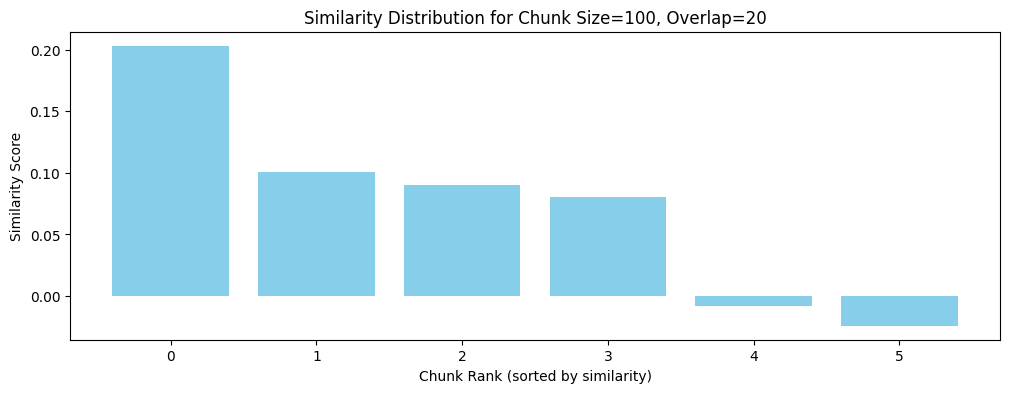

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

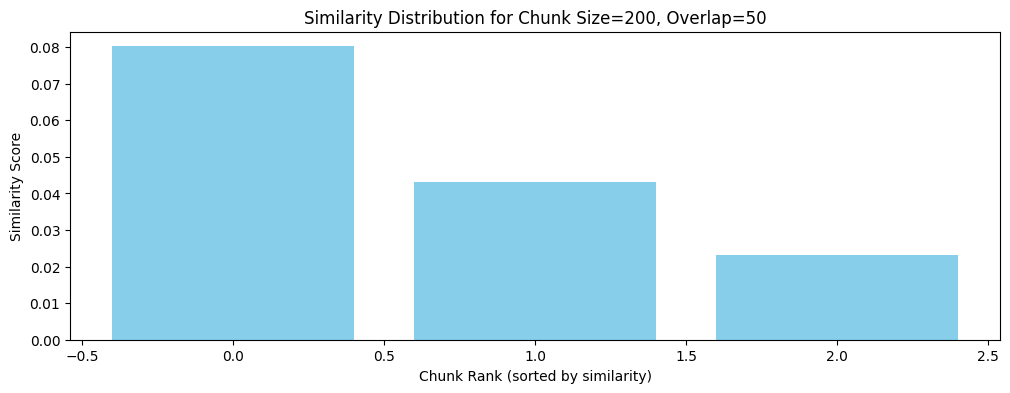

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

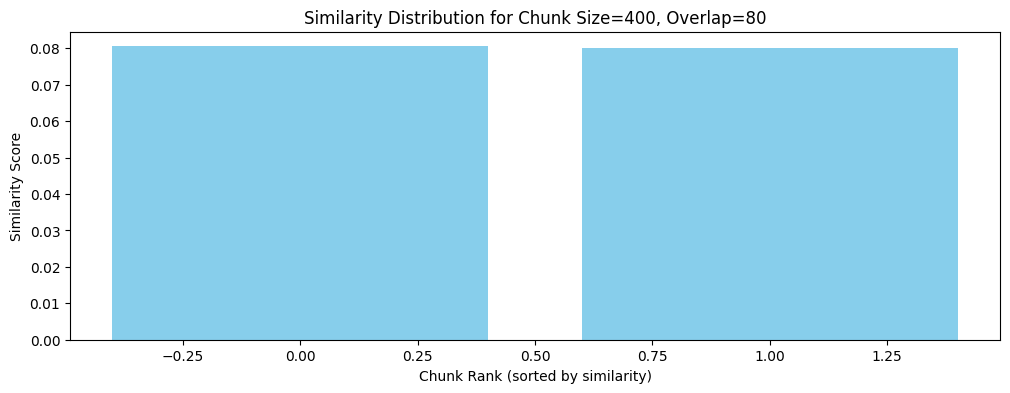

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_retrieval_similarity(chunks_local, store_local, question, title):
    q_emb = embed_query(question)
    sims = [cosine_similarity(q_emb, e) for e in store_local.embeddings]
    sims = np.array(sims)

    # sort indices for nicer plotting
    sorted_idx = np.argsort(sims)[::-1]
    sorted_sims = sims[sorted_idx]

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(sorted_sims)), sorted_sims, color="skyblue")
    plt.title(title)
    plt.xlabel("Chunk Rank (sorted by similarity)")
    plt.ylabel("Similarity Score")
    plt.show()

# Plot for each setting
for (cs, co), (ans, retrieved) in experiment_results.items():
    chunks_ex, store_ex = build_rag_pipeline(cs, co)
    title = f"Similarity Distribution for Chunk Size={cs}, Overlap={co}"
    plot_retrieval_similarity(chunks_ex, store_ex, q, title)


## 11. Exercise 2 – Multiple PDFs

**Goal:** Extend RAG to handle multiple PDFs at once.

Instructions:

1. Add another PDF file into `data/sample_papers/` (e.g. `paper2.pdf`).
2. Update `sample_pdf_paths` to include both `paper1.pdf` and `paper2.pdf`.
3. Re-run:
   - Loading
   - Chunking
   - Embedding
   - Vector store creation
4. Ask a question that should clearly belong to **only one** of the PDFs.
   - Check if the retrieved chunks come from the right document.


In [19]:
# === Multi-PDF RAG Pipeline Demo ===

# 1. Point to multiple PDFs
sample_pdf_paths = [
    str(pdf_dir / "paper1.pdf"),
    str(pdf_dir / "paper2.pdf"),
    # add more if you want:
    # str(pdf_dir / "paper3.pdf"),
]

print("Using the following PDFs:")
for p in sample_pdf_paths:
    print(" -", p)

# 2. Reload and rebuild the pipeline for ALL PDFs together
raw_text = load_pdfs(sample_pdf_paths)
print("\nTotal characters across all PDFs:", len(raw_text))

chunks = chunk_text(raw_text, chunk_size=200, chunk_overlap=50)
print("Total chunks:", len(chunks))

chunk_embeddings = embed_documents(chunks)
vector_store = SimpleVectorStore(embeddings=chunk_embeddings, texts=chunks)

# 3. Ask two questions:
#    - q1 should be clearly about content from paper1
#    - q2 should be clearly about content from paper2
q1 = "Question related specifically to the topic of paper 1 goes here."
q2 = "Question related specifically to the topic of paper 2 goes here."

def run_rag_demo(question: str, k: int = 3):
    print("\n" + "=" * 80)
    print("QUESTION:")
    print(question)
    print("=" * 80)
    
    answer, retrieved = answer_with_rag(question, k=k)
    
    print("\nANSWER:")
    print(answer)
    
    print("\nTop retrieved chunks:")
    for i, (chunk, score) in enumerate(retrieved):
        print(f"\n--- Chunk {i} (score={score:.4f}) ---")
        print(chunk[:400], "...")
        
# 4. Run RAG for both questions
run_rag_demo(q1, k=3)
run_rag_demo(q2, k=3)


Using the following PDFs:
 - data/sample_papers/paper1.pdf
 - data/sample_papers/paper2.pdf

Total characters across all PDFs: 7623
Total chunks: 8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


QUESTION:
Question related specifically to the topic of paper 1 goes here.

ANSWER:
I don't know based on the provided documents.

Top retrieved chunks:

--- Chunk 0 (score=0.0955) ---
| Astronomer • Model Context Protocol | Anthropic PUBLICATIONS https://ieeexplore.ieee.org/document/10782852 Advancing Medical Imaging: A Comparative Exploration of Generative Adversarial Networks for Chest X-ray Synthesis ...

--- Chunk 1 (score=0.0779) ---
=== PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  Style: cute  Visible Features: panda design, imported premium case 3. Seller Description  Original Text: Pink Phone Case  Tone: minimal  Keywords: pink, phone case  Claims: the product is a phone c ...

--- Chunk 2 (score=0.0676) ---
I found it a bit slippery, making it hard to hold. It also doesn't seem as durable—I worry it won't last long. For the

In [21]:
# === Rebuild multi-PDF chunks WITH document labels ===

# Make sure sample_pdf_paths contains all your PDFs
sample_pdf_paths = [
    str(pdf_dir / "paper1.pdf"),
    str(pdf_dir / "paper2.pdf"),
    str(pdf_dir / "paper3.pdf"),
]

pdf_texts = [load_pdfs([p]) for p in sample_pdf_paths]

all_chunks = []
doc_labels = []

chunk_size = 200
chunk_overlap = 50

for doc_index, text in enumerate(pdf_texts):
    # Chunk this PDF's text
    doc_chunks = chunk_text(text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    
    # Extend global chunk list
    all_chunks.extend(doc_chunks)
    
    # Label each chunk with its PDF number
    label = f"PDF {doc_index + 1}"
    doc_labels.extend([label] * len(doc_chunks))

# Replace the old chunks with the new ones
chunks = all_chunks

# Recompute embeddings and vector store for these new chunks
chunk_embeddings = embed_documents(chunks)
vector_store = SimpleVectorStore(embeddings=chunk_embeddings, texts=chunks)

print(f"Total PDFs: {len(sample_pdf_paths)}")
print(f"Total chunks: {len(chunks)}")
print("Sample labels:", doc_labels[:10])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Total PDFs: 3
Total chunks: 14
Sample labels: ['PDF 1', 'PDF 1', 'PDF 1', 'PDF 2', 'PDF 2', 'PDF 2', 'PDF 2', 'PDF 2', 'PDF 3', 'PDF 3']


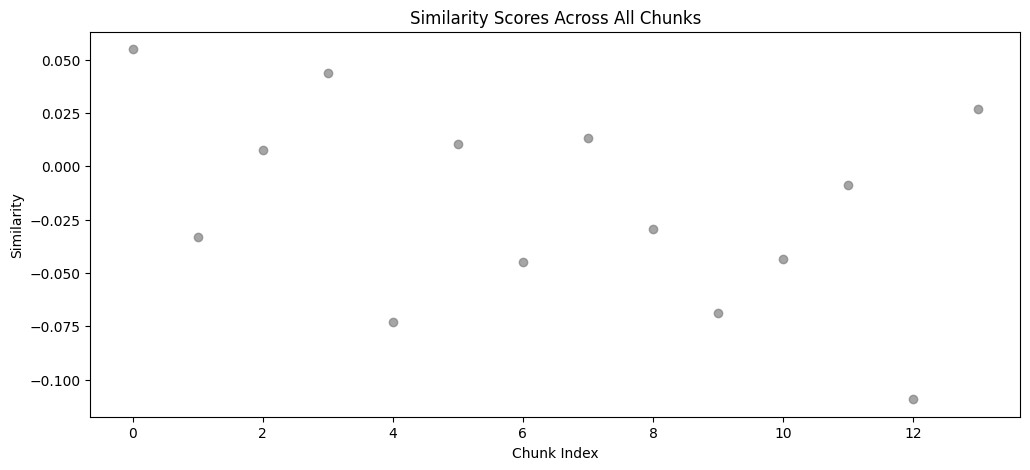


Retrieved Chunks and Their Source PDFs:

Rank 1: Score=0.0548 | Source=PDF 1
=== PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  Style: cute  Visible Features: panda design, import ...

Rank 2: Score=0.0438 | Source=PDF 2
Kiran Rao Snowflake | ETLs | Dashboards | LLMs | Hugging Face | SQL sathyasunkojirao.k@northeastern.edu | 617-516-3845 | linkedin.com/in/kiran-ss | Portfolio EDUCATION Master of Science in Information systems | Northeastern University | Boston, MA Se ...

Rank 3: Score=0.0270 | Source=PDF 3
Strong attention to detail with the ability to communicate insights clearly to both technical and non-technical audiences • Collaborative team player with strong service orientation, organizational, problem-solving, and multi-tasking skills ...

Rank 4: Score=0.0130 | Source=PDF 2
Pinecone AI technologies : LangChain, LangGraph, Agentic

In [22]:
def visualize_multi_pdf_retrieval(question, k=5):
    q_emb = embed_query(question)
    sims = [cosine_similarity(q_emb, e) for e in chunk_embeddings]

    # Plot similarities
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.scatter(range(len(sims)), sims, c="gray", alpha=0.7)
    plt.title("Similarity Scores Across All Chunks")
    plt.xlabel("Chunk Index")
    plt.ylabel("Similarity")
    plt.show()

    # Print retrieved chunks + which PDF they came from
    retrieved = retrieve_chunks(question, k)
    print("\nRetrieved Chunks and Their Source PDFs:\n")
    for i, (chunk, score) in enumerate(retrieved):
        # Find index of the chunk in our global chunks list
        idx = chunks.index(chunk)
        source = doc_labels[idx]
        print(f"Rank {i+1}: Score={score:.4f} | Source={source}")
        print(chunk[:250], "...\n")

# Example:
visualize_multi_pdf_retrieval("Ask a question that clearly belongs to one PDF")


## 12. Exercise 3 – Similarity Threshold (Optional)

Sometimes retrieval returns **barely relevant** chunks.

Idea: only accept chunks above a certain similarity threshold (e.g., 0.3).

**Task:**

1. Modify `SimpleVectorStore.search` (or write a new method) to:
   - Return only chunks where `similarity >= threshold`.
2. See what happens when you:
   - Set a high threshold (e.g., 0.6).
   - Set a low threshold (0.1).

Think: does answer quality improve or degrade?


In [24]:
# === Exercise 3: Similarity Threshold Demo ===

from dataclasses import dataclass

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return float(a @ b / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10))

@dataclass
class SimpleVectorStore:
    embeddings: np.ndarray   # shape (n_docs, dim)
    texts: List[str]

    def search(
        self,
        query_embedding: np.ndarray,
        k: int = 5,
        threshold: float | None = None
    ) -> List[Tuple[str, float]]:
        """
        Return top-k (text, similarity) pairs.
        If threshold is provided, filter out any results with similarity < threshold.
        """
        sims = [cosine_similarity(query_embedding, e) for e in self.embeddings]
        idxs = np.argsort(sims)[::-1]  # sort high → low
        
        results = []
        for i in idxs:
            score = sims[i]
            if threshold is not None and score < threshold:
                continue
            results.append((self.texts[i], score))
            if len(results) >= k:
                break
        return results

# Rebuild the vector store using the redefined class
chunk_embeddings = embed_documents(chunks)
vector_store = SimpleVectorStore(embeddings=chunk_embeddings, texts=chunks)

def retrieve_chunks_with_threshold(
    question: str,
    k: int = 5,
    threshold: float | None = None
) -> List[Tuple[str, float]]:
    q_emb = embed_query(question)
    return vector_store.search(q_emb, k=k, threshold=threshold)

def answer_with_rag_and_threshold(
    question: str,
    k: int = 5,
    threshold: float | None = None
) -> Tuple[str, List[Tuple[str, float]]]:
    results = retrieve_chunks_with_threshold(question, k=k, threshold=threshold)
    chunks_only = [c for c, _ in results]
    prompt = build_rag_prompt(question, chunks_only)
    answer = llm.generate(prompt)
    return answer, results

# 🔍 Try it out: same question, different thresholds
question = "Summarize the main contribution of this document."

print("===== No threshold =====")
answer_no_thr, retrieved_no_thr = answer_with_rag_and_threshold(
    question,
    k=5,
    threshold=None
)
print("\nANSWER:\n", answer_no_thr[:700])

print("\nRetrieved chunks (no threshold):")
for i, (chunk, score) in enumerate(retrieved_no_thr):
    print(f"\n--- Chunk {i} (score={score:.4f}) ---")
    print(chunk[:300], "...")

print("\n\n===== High threshold (e.g., 0.6) =====")
answer_high_thr, retrieved_high_thr = answer_with_rag_and_threshold(
    question,
    k=5,
    threshold=0.6
)
print("\nANSWER:\n", answer_high_thr[:700])

print("\nRetrieved chunks (threshold=0.6):")
if not retrieved_high_thr:
    print("No chunks passed the threshold.")
else:
    for i, (chunk, score) in enumerate(retrieved_high_thr):
        print(f"\n--- Chunk {i} (score={score:.4f}) ---")
        print(chunk[:300], "...")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

===== No threshold =====

ANSWER:
 The document outlines the qualifications, technical skills, and project experience of a data professional skilled in building economic analytics tools, data pipelines, and dashboards using Python, Snowflake, Airflow, and BI tools like Tableau and Power BI. It highlights expertise in integrating APIs, maintaining data lineage, documenting codebases, and using generative AI to automate workflows and enhance insights. The individual demonstrates strong problem-solving, collaboration, and communication skills, with a focus on continuous learning and contributing to impactful data-driven projects in collaboration with global teams and experts.

Retrieved chunks (no threshold):

--- Chunk 0 (score=0.2469) ---
Strong attention to detail with the ability to communicate insights clearly to both technical and non-technical audiences • Collaborative team player with strong service orientation, organizational, problem-solving, and multi-tasking skills ...

--- Ch

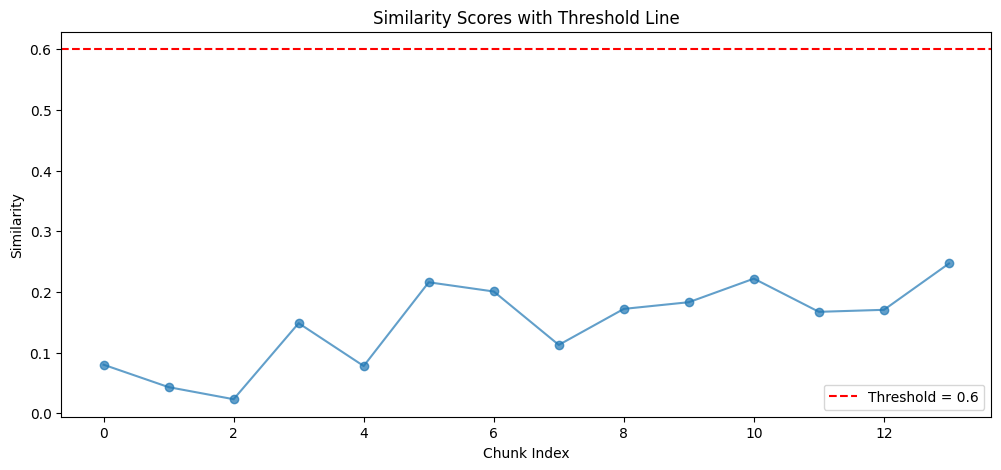


Retrieved 0 chunks above threshold:


In [25]:
def plot_threshold_effect(question, threshold=0.6, k=5):
    q_emb = embed_query(question)
    sims = np.array([cosine_similarity(q_emb, e) for e in chunk_embeddings])

    plt.figure(figsize=(12, 5))
    plt.plot(sims, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")

    plt.title("Similarity Scores with Threshold Line")
    plt.xlabel("Chunk Index")
    plt.ylabel("Similarity")
    plt.legend()
    plt.show()

    # Retrieve using threshold
    retrieved = vector_store.search(q_emb, k=k, threshold=threshold)

    print(f"\nRetrieved {len(retrieved)} chunks above threshold:")
    for i, (chunk, score) in enumerate(retrieved):
        print(f" - Chunk {i}: {score:.4f}")

plot_threshold_effect("Summarize the main contribution of this document.", threshold=0.6)


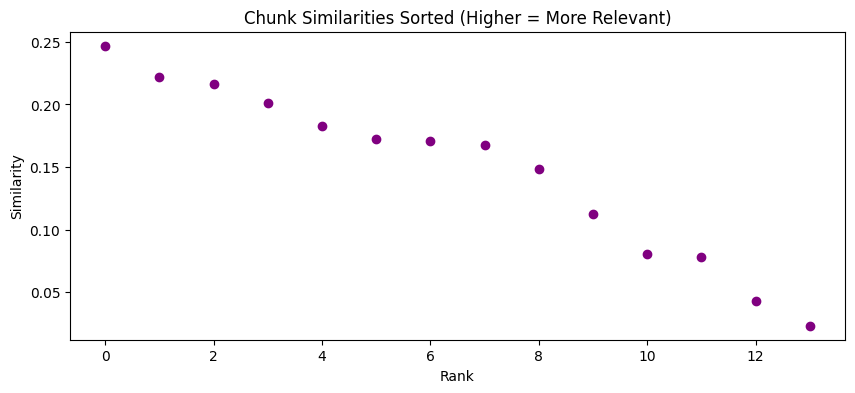

In [26]:
def similarity_scatter(question):
    q_emb = embed_query(question)
    sims = np.array([cosine_similarity(q_emb, e) for e in chunk_embeddings])
    sorted_sims = np.sort(sims)[::-1]

    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(sorted_sims)), sorted_sims, color='purple')
    plt.title("Chunk Similarities Sorted (Higher = More Relevant)")
    plt.xlabel("Rank")
    plt.ylabel("Similarity")
    plt.show()

similarity_scatter("Summarize the main contribution of this document.")


## 13. Debugging RAG – Notes to Myself

Common problems and how I would debug them:

1. **Empty or weird PDF text**
   - Symptom: chunks look like gibberish or are empty.
   - Fix:
     - Check `raw_text[:500]`.
     - Try a different PDF or OCR if it's scanned.

2. **Irrelevant retrieval**
   - Symptom: chunks don't match question.
   - Fix:
     - Print top-k chunks and inspect manually.
     - Adjust chunk size / overlap.
     - Increase or decrease `k`.

3. **Hallucinated answers**
   - Symptom: answer says things *not present* in retrieved chunks.
   - Fix:
     - Strengthen instructions in the prompt to only use context.
     - Show retrieved chunks and check if answer is actually grounded.
     - Maybe retrieve more chunks.

4. **Performance / speed issues**
   - Symptom: slow embedding.
   - Fix:
     - Use a smaller embedding model.
     - Cache embeddings (don't recompute every run).


In [27]:
# ================================================================
# 🔧 RAG DEBUGGING SUITE
# Runs a full set of diagnostic checks to identify common issues.
# ================================================================

def rag_debug(question, threshold=None, k=5):
    print("="*80)
    print("🔍 RAG DEBUGGING REPORT")
    print("="*80)

    # ------------------------------------------
    # 1. Check PDF text quality
    # ------------------------------------------
    print("\n[1] Checking PDF text extraction...")
    if len(raw_text.strip()) < 100:
        print("❌ PDF text is too short — extraction likely failed.")
    else:
        print(f"✅ PDF text length: {len(raw_text)} characters")

    sample_preview = raw_text[:400].replace("\n", " ")
    print("📝 Text preview:", sample_preview[:400], "...\n")

    # ------------------------------------------
    # 2. Check chunking
    # ------------------------------------------
    print("[2] Checking chunk generation...")
    print(f"Total chunks: {len(chunks)}")
    if len(chunks) == 0:
        print("❌ No chunks created — chunking failed!")
        return
    elif len(chunks) < 5:
        print("⚠️ Very few chunks — chunk size may be too large.")
    else:
        print("✅ Chunking appears normal.")

    print("📏 Sample chunk:", chunks[0][:200], "...\n")

    # ------------------------------------------
    # 3. Check embeddings
    # ------------------------------------------
    print("[3] Checking embeddings...")
    try:
        dim = chunk_embeddings.shape[1]
        print(f"✅ Embeddings shape: {chunk_embeddings.shape} (dimension={dim})")
    except:
        print("❌ Embeddings missing or incorrectly shaped.")
        return

    # ------------------------------------------
    # 4. Check retrieval
    # ------------------------------------------
    print("\n[4] Checking retrieval...")
    q_emb = embed_query(question)
    retrieved = vector_store.search(q_emb, k=k, threshold=threshold)

    if len(retrieved) == 0:
        print(f"❌ No chunks retrieved! Threshold={threshold} may be too high.")
        return
    else:
        print(f"✅ Retrieved {len(retrieved)} chunks (k={k}, threshold={threshold})")

    # Show retrieved chunks + scores
    for i, (chunk, score) in enumerate(retrieved):
        print(f"\n   → Chunk {i} | score={score:.4f}")
        print("     ", chunk[:180].replace("\n", " "), "...")

    # ------------------------------------------
    # 5. Check RAG prompt construction
    # ------------------------------------------
    print("\n[5] Checking RAG prompt assembly...")
    rg_prompt = build_rag_prompt(question, [c for c, _ in retrieved])
    print("📝 Prompt preview:")
    print(rg_prompt[:500], "...\n")
    if "Context:" not in rg_prompt or "Question:" not in rg_prompt:
        print("❌ Prompt missing required fields!")
    else:
        print("✅ Prompt correctly constructed.")

    # ------------------------------------------
    # 6. Check LLM response
    # ------------------------------------------
    print("[6] Checking LLM generation...")
    try:
        ans = llm.generate(rg_prompt)
        print("✅ LLM generated a response:")
        print(ans[:500], "...\n")
    except Exception as e:
        print("❌ LLM call failed!")
        print("Error:", e)
        return

    print("="*80)
    print("✔ DEBUGGING COMPLETE — If issues exist, follow suggestions above.")
    print("="*80)


# ================================================================
# Run Debug Test
# ================================================================
test_question = "What is the main contribution of this document?"
rag_debug(test_question, threshold=None, k=5)


🔍 RAG DEBUGGING REPORT

[1] Checking PDF text extraction...
✅ PDF text length: 7623 characters
📝 Text preview: === PRODUCT REPORT === 1. Basic Product Details     Category: Phone case     Price: $20.00     AI Caption (from image): pink phone case with panda design 2. Image Analysis     Color: pink     Material: N/A     Style: cute     Visible Features: panda design, imported premium case 3. Seller Description     Original Text: Pink Phone Case     Tone: minimal     Keywords: pink, phone case     ...

[2] Checking chunk generation...
Total chunks: 14
✅ Chunking appears normal.
📏 Sample chunk: === PRODUCT REPORT === 1. Basic Product Details  Category: Phone case  Price: $20.00  AI Caption (from image): pink phone case with panda design 2. Image Analysis  Color: pink  Material: N/A  St ...

[3] Checking embeddings...
✅ Embeddings shape: (14, 384) (dimension=384)

[4] Checking retrieval...
✅ Retrieved 5 chunks (k=5, threshold=None)

   → Chunk 0 | score=0.1718
      to gen

## 14. Summary & Next Steps

In this notebook, I:

- Implemented a **minimal RAG system**:
  - Loaded one or more PDFs.
  - Chunked text with overlap.
  - Embedded chunks using `sentence-transformers`.
  - Stored them in a simple in-memory vector store.
  - Retrieved top-k chunks for a question.
  - Used OpenAI's Chat Completions to answer based on those chunks.

Key ideas I learned:

- RAG ≠ fine-tuning. It’s about **retrieval + prompting**, not changing model weights.
- Chunking and retrieval quality are **crucial** (GIGO).
- It’s important to actually **inspect retrieved context** and not blindly trust the LLM.
- Small architectural decisions (chunk size, `k`, threshold) can significantly affect answer quality.

**Possible extensions:**

- Swap in a different embedding model.
- Use FAISS or a real vector database.
- Build a small Streamlit UI to turn this into a "Chat with your PDFs" app.
- Add evaluation: create a small QA set and measure how often RAG answers correctly.

This notebook will become the basis for:

- My teaching tutorial (`rag_tutorial.md`).
- The show-and-tell video (Explain → Show → Try).
- Exercises and debugging guide in the final project.
